In [1]:

%pprint
import sys
sys.path.insert(1, '../py')
from notebook_utils import NotebookUtilities

%matplotlib inline
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import textwrap
import warnings

nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))

# Turn off warnings
warnings.filterwarnings('ignore')

Pretty printing has been turned OFF


In [2]:

generations_df = nu.load_object('generations_df')
turning_numbers_df = nu.load_object('turning_numbers_df')
turnings_df = nu.load_object('turnings_df')

In [3]:

# nu.get_dir_tree('NotebookUtilities', contains_str=None, not_contains_str=None)


# Universities

Most top universities are below 500ft in elevation.

In [5]:

if nu.pickle_exists('university_elevations_df'):
    university_elevations_df = nu.load_object('university_elevations_df')
else:
    # Open the file in read mode
    file_path = r'C:\Users\daveb\OneDrive\Documents\GitHub\transcriptions-notebook\saves\txt\left.txt'

    # Read the file line by line and extract information
    rows_list = []
    with open(file_path, 'r') as file:
        for line in file:

            # Check if the line contains university information
            if line.strip().startswith('|'):

                # Split the line into columns, extract relevant data, and append data to respective lists
                data = line.strip().split('|')
                rank = data[1].strip()
                if rank.isdigit():
                    row_dict = {}
                    row_dict['QS World University Rankings 2024'] = rank
                    row_dict['University'] = data[2].strip()
                    row_dict['Location'] = data[3].strip()
                    rows_list.append(row_dict)

    # Convert the extracted information into a data frame
    university_elevations_df = pd.DataFrame(rows_list)
    
    # Get the Wikipedia URLs
    import wikipedia
    from bs4 import BeautifulSoup as bs
    for row_index, row_series in university_elevations_df.iterrows():
        university_name = row_series.University
        university_location = row_series.Location
        search_str = f'{university_name}, {university_location}'
        try:
            page_obj = wikipedia.page(title=search_str)
            wikipedia_url = page_obj.url
            # page_html = page_obj.html()
            # page_soup = bs(page_html, 'html.parser')
        except Exception as e:
            print(f'{search_str} got this error: {str(e).strip()}')
            wikipedia_url = row_series.wikipedia_url
        university_elevations_df.loc[row_index, 'wikipedia_url'] = wikipedia_url
    
    nu.store_objects(university_elevations_df=university_elevations_df)

In [6]:

display(university_elevations_df.sample(min(3, university_elevations_df.shape[0])).dropna(axis='columns', how='all').T.sample(
    min(20, university_elevations_df.shape[1])
))

,2,18,21
university_vice_chancellor,Irene Tracey,NaN,NaN
location_gdp,NaN,NaN,$33 billion
location_established,NaN,26 January 1788,NaN
location_ons_code,38UC (ONS)E07000178 (GSS),NaN,S12000036
location_county,NaN,Cumberland,NaN
location_lga_s,NaN,Various (33),NaN
location_sovereign_state,United Kingdom,NaN,United Kingdom
university_motto_in_english,The Lord is my light,"Knowledge by Heart, Hand and Mind",NaN
wikipedia_url,https://en.wikipedia.org/wiki/University_of_Ox...,https://en.wikipedia.org/wiki/University_of_Ne...,https://en.wikipedia.org/wiki/University_of_Ed...
location_website,www.oxford.gov.uk,NaN,www.edinburgh.gov.uk


In [7]:

mask_series = university_elevations_df.wikipedia_url.isnull()
for row_index, row_series in university_elevations_df[~mask_series].iterrows():
    
    # Get the univesity infobox data
    wikipedia_url = row_series.wikipedia_url
    page_soup = nu.get_page_soup(wikipedia_url, verbose=False)
    for th_soup in page_soup.find_all(
        name='th',
        attrs={'scope': 'row', 'class': 'infobox-label'},
        recursive=True,
    ):
        
        # Get the key
        key = th_soup.text
        key = 'university_' + re.sub(r'[^A-Za-z0-9]+', '_', str(key).split('[')[0]).strip('_').lower()
        
        # Get the value
        td_soup = th_soup.find_next_sibling(name='td', attrs={'class': 'infobox-data'})
        if (key == 'university_location'):
            a_tag = td_soup.find_all(name='a', title=True)[0]
            value = a_tag['title']
            
            # Get the location infobox data
            location_url = 'https://en.wikipedia.org' + a_tag['href']
            location_soup = nu.get_page_soup(location_url, verbose=False)
            for location_th_soup in location_soup.find_all(
                name='th',
                attrs={'scope': 'row', 'class': 'infobox-label'},
                recursive=True,
            ):
                
                # Get the location key
                location_key = location_th_soup.text
                location_key = 'location_' + re.sub(r'[^A-Za-z0-9]+', '_', str(location_key).split('[')[0]).strip('_').lower()
                
                # Get the location value
                location_td_soup = location_th_soup.find_next_sibling(name='td', attrs={'class': 'infobox-data'})
                location_value = location_td_soup.text
                location_value = re.sub(r'[ \u2009\xa0]+', ' ', str(location_value).split('[')[0].strip())

                university_elevations_df.loc[row_index, location_key] = location_value
            
        else: value = td_soup.text
        value = re.sub(r'[ \u2009\xa0]+', ' ', str(value).split('[')[0].strip())

        university_elevations_df.loc[row_index, key] = value

In [8]:

display(university_elevations_df.sample(min(3, university_elevations_df.shape[0])).dropna(axis='columns', how='all').T.sample(
    min(20, university_elevations_df.shape[1])
))

,20,14,15
university_endowment,c. C$3.15 billion (excl. colleges),$4.6 billion (2021),$42.3 billion (2022)
location_urban,"1,792.99 km2 (692.28 sq mi)",NaN,"561,456 (US: 77th)"
location_u_s_state,NaN,NaN,Connecticut
university_yield_rate,NaN,50.0% ( +8.6),NaN
location_gnis_feature_id,NaN,NaN,0209231
university_accreditation,NaN,WSCUC,NECHE
wikipedia_url,https://en.wikipedia.org/wiki/University_of_To...,https://en.wikipedia.org/wiki/California_Insti...,https://en.wikipedia.org/wiki/Yale_University
location_incorporated,"March 6, 1834; 189 years ago (1834-03-06) (as ...","June 19, 1886; 137 years ago (1886-06-19)",NaN
location_total,NaN,"138,699",NaN
location_amalgamated,"January 1, 1998; 25 years ago (1998-01-01) (as...",NaN,NaN


In [9]:

[cn for cn in university_elevations_df.columns if 'levation' in cn]

['location_elevation', 'location_highest_elevation_charles_mound', 'location_lowest_elevation_confluence_of_mississippi_river_and_ohio_river', 'location_elevation_metres']

Pickling to C:\Users\daveb\OneDrive\Documents\GitHub\Strauss-Howe\saves\pkl\university_elevations_df.pkl


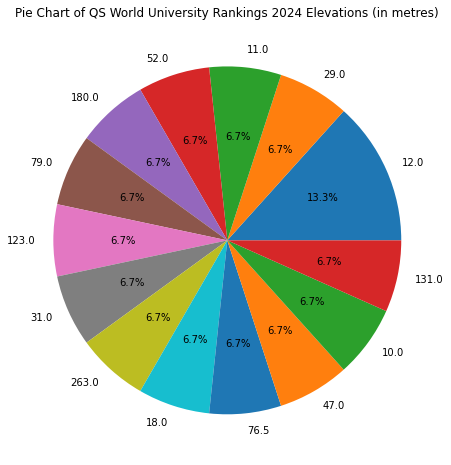

In [10]:

# Create a pie chart for the location_key column
metre_regex = re.compile(r'([0-9\.]+) \bm\b')
def f(x):
    match_obj = metre_regex.search(str(x))
    if match_obj: elevation_metres = float(match_obj.group(1))
    else: elevation_metres = np.nan
    
    return elevation_metres
university_elevations_df['location_elevation_metres'] = university_elevations_df.location_elevation.map(f)
nu.store_objects(university_elevations_df=university_elevations_df)
plt.figure(figsize=(8, 8))
plt.pie(
    university_elevations_df.location_elevation_metres.value_counts(), labels=university_elevations_df.location_elevation_metres.value_counts().index,
    autopct='%1.1f%%'
)
plt.title('Pie Chart of QS World University Rankings 2024 Elevations (in metres)');

In [11]:

mask_series = ~university_elevations_df.location_elevation_metres.isnull()
university_elevations_df[mask_series].location_elevation_metres.value_counts().sort_index()

10.0     1
11.0     1
12.0     2
18.0     1
29.0     1
31.0     1
47.0     1
52.0     1
76.5     1
79.0     1
123.0    1
131.0    1
180.0    1
263.0    1
Name: location_elevation_metres, dtype: int64

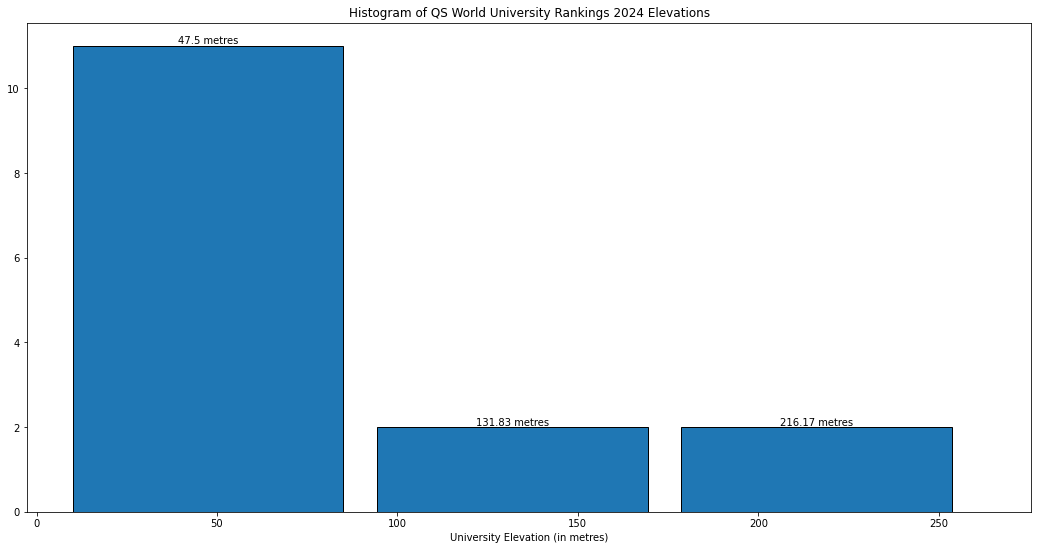

In [12]:

fig, ax = plt.subplots(figsize=(18, 9))
university_elevations_df[mask_series].sort_values('location_elevation_metres').location_elevation_metres.hist(
    ax=ax, bins=3, align='mid', edgecolor='black', width=75
)

# Set the title and labels
title = 'Histogram of QS World University Rankings 2024 Elevations'
ax.set_title(title)
xlabel = 'University Elevation (in metres)'
ax.set_xlabel(xlabel)

# Turn the grid off
plt.grid(False)

# Get the height of each bar
bar_xs = []
bar_ys = []
for rectangle_obj in ax.patches:
    bbox_obj = rectangle_obj.get_bbox()
    bar_xs.append((bbox_obj.xmax + bbox_obj.xmin) / 2)
    bar_ys.append(bbox_obj.ymax)

# Add labels above the bars
for x, y in zip(
    bar_xs, bar_ys
):
    if y:
        ax.annotate(
            f'{round(x, 2)} metres',
            xy=(x, y),
            ha='center',
            va='bottom',
            fontsize=10,
        );

In [13]:

[fn for fn in dir(rectangle_obj) if fn.startswith('get_')]

['get_aa', 'get_agg_filter', 'get_alpha', 'get_animated', 'get_antialiased', 'get_bbox', 'get_capstyle', 'get_children', 'get_clip_box', 'get_clip_on', 'get_clip_path', 'get_contains', 'get_cursor_data', 'get_data_transform', 'get_ec', 'get_edgecolor', 'get_extents', 'get_facecolor', 'get_fc', 'get_figure', 'get_fill', 'get_gid', 'get_hatch', 'get_height', 'get_in_layout', 'get_joinstyle', 'get_label', 'get_linestyle', 'get_linewidth', 'get_ls', 'get_lw', 'get_patch_transform', 'get_path', 'get_path_effects', 'get_picker', 'get_rasterized', 'get_sketch_params', 'get_snap', 'get_tightbbox', 'get_transform', 'get_transformed_clip_path_and_affine', 'get_url', 'get_verts', 'get_visible', 'get_width', 'get_window_extent', 'get_x', 'get_xy', 'get_y', 'get_zorder']

In [14]:

bbox_obj = rectangle_obj.get_bbox()
print(bbox_obj)
print(bbox_obj.x0, bbox_obj.x1, bbox_obj.xmax, bbox_obj.xmin, bbox_obj.y0, bbox_obj.y1, bbox_obj.ymax, bbox_obj.ymin)

Bbox(x0=178.66666666666663, y0=0.0, x1=253.66666666666663, y1=2.0)
178.66666666666663 253.66666666666663 253.66666666666663 178.66666666666663 0.0 2.0 2.0 0.0


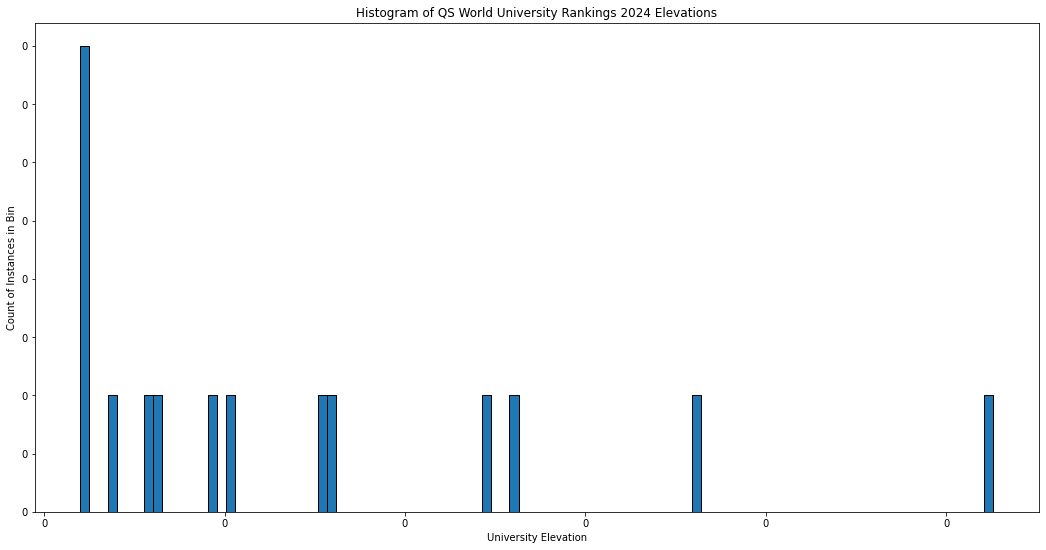

In [15]:

get_xtick_text = lambda text_obj: text_obj.get_position()[1]
nu.plot_histogram(university_elevations_df, 'location_elevation_metres', 'University Elevation', xtick_text_fn=get_xtick_text, title=title, ax=None)

In [16]:

pd.cut?

Signature:
pd.cut(
    x,
    bins,
    right: 'bool' = True,
    labels=None,
    retbins: 'bool' = False,
    precision: 'int' = 3,
    include_lowest: 'bool' = False,
    duplicates: 'str' = 'raise',
    ordered: 'bool' = True,
)
Docstring:
Bin values into discrete intervals.

Use `cut` when you need to segment and sort data values into bins. This
function is also useful for going from a continuous variable to a
categorical variable. For example, `cut` could convert ages to groups of
age ranges. Supports binning into an equal number of bins, or a
pre-specified array of bins.

Parameters
----------
x : array-like
    The input array to be binned. Must be 1-dimensional.
bins : int, sequence of scalars, or IntervalIndex
    The criteria to bin by.

    * int : Defines the number of equal-width bins in the range of `x`. The
      range of `x` is extended by .1% on each side to include the minimum
      and maximum values of `x`.
    * sequence of scalars : Defines the bin edges allowing